<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Train/Test Split and Bias and Variance

_Authors: Joseph Nelson (DC), Kevin Markham (DC)_

---

<a id="learning-objectives"></a>
<a id="learning-objectives"></a>
<a id="learning-objectives"></a>
### Learning Objectives
- Characterize the difference between error due to bias and error due to variance.
- Identify the bias-variance trade-off.
- Describe what overfitting and underfitting means in the context of model building.
- Explain problems associated with over- and underfitting.
- Grasp why train/test split is necessary.
- Explore k-folds, LOOCV, and three split methods.

# Bias

Linear regression with one input feature finds the *line* that best fits the data. This is what you want if in fact $y = \beta_0 + \beta_1 * x + \epsilon$, where $\epsilon$ is normally distributed random noise.

![](./assets/linear.png)

But if, say, $y = \beta_0 + \beta_1 x + \beta_2 x^2 +\epsilon$, then "the line that best fits the data" is *not* what you want.

![](./assets/quadratic.png)

This difference between the kind of relationship a model can capture and the kind that exists in the underlying data-generating process (the "true model") is called **bias**.

Because it is due to a fundamentally mis-specified model, *bias doesn't go away as you collect more data.*

# Variance

One way to address bias is to make your model more flexible. For instance, a model that finds the best-fitting parabola $y = \beta_0 + \beta_1 X + \beta_2 X^2$ can do everything a linear model can do (setting $\beta_2=0$) and more, so it can only be better in terms of bias.

Why stop there? Why not $y = \beta_0 + \beta_1 X + \beta_2 X^2 + \beta_3 X^3 + \beta_4 X^4 + \beta_5 X^5 + \beta_6 X^6 + \beta_7 X^7 + \beta_8 X^8$?

The problem why this approach is that more flexible models are more sensitive to that random noise $\epsilon$ in the data. They find "patterns" that aren't really there.

![](./assets/overfit.png)

Because they are sensitive to random noise in the data, overly flexible models will give very different results on datasets that are drawn from the same distribution.

![](./assets/overfit_side_by_side.png)

For this reason, we say that overly flexible models have high **variance**.

As sample size increases, even a very flexible model will learn to distinguish between signal and noise. As a result, *model variance does go away as you collect more data*.

<a id="bias-and-variance-trade-off"></a>
## Bias-Variance Tradeoff

**Exercise.** State whether each of the following changes you can make to a model would increase, decrease, or leave unchanged (1) model bias and (2) model variance, or whether its effect on those quantities cannot be determined from the information given.

- Include more of the variables that are given in your dataframe in your feature columns.

-- decrease model bias
-- variance increases

- Add the square of one of your feature columns as a new feature column.

-- decrease model bias
-- variance increases

- Replace one feature column with its logarithm.

depends which version of the variable is better fit the model

- Collect more data.

-- decreases variance
-- bias remains unchanged

- Modify the procedure you use to fit your model so that instead of minimizing the sum of squared errors, it minimizes the sum of squared errors plus a penalty term that increases with the coefficients of the model. (This approach is an example of *regularization*.)

-- u r making ur model less flexible
-- bias goes up
-- variance goes down

- Instead of linear regression, use a *generative additive model* that can fit a variety of non-linear relationships between your features and your target variable as well as linear relationships.

-- made our mode more flexible
-- mean decreasing bias
-- increasing variance

### Expressing bias and variance mathematically

Assume that there is some function $f$ such that $y=f(X)+\epsilon$ for a given input feature matrix $X$ and target variable $y$, where $\epsilon$ is normally distributed with variance $\sigma^2$. We will call this $f$ the "true model" for $y$ based on $X$. We will use $\hat{f}(X)$ ("$f$-hat of $X$") to denote a particular model's predictions for $y$ given an input feature matrix $X$.

Suppose you performed the following steps repeatedly: 

1. Draw a random sample of a given size from a particular data-generating process -- the "training set."
2. Fit a particular kind of model to that training set.
3. Draw one additional point $X^*$ from the same data-generating process and calculate the squared error of the model's prediction on that point.

The expected (long-run average) value of that squared error can be broken down into three components:

$\mbox{Expected Squared Error} = \mbox{Bias}^2 + \mbox{Variance} + \mbox{Irreducible Error}$

where
- $\mbox{Expected Squared Error} = E[(y-\hat{f}(X^*))^2]$
    - (expected squared difference between the target value and the model's prediction)
- $\mbox{Bias} = E[\hat{f}(X^*) - f(X^*)]$
    - (expected difference between a prediction from the model and a prediction from the true model)
- $\mbox{Variance} = E[(\hat{f}(X^*) - E[\hat{f}(X^*)])^2]$
    - (expected squared difference between the model's prediction and its expected prediction)
- $\mbox{Irreducible Error} = \sigma^2$
    - (noise in the data-generating mechanism)

### Example

Suppose you build a linear model to predict the weights of golden retrievers when they are one year old based on their weights when they are seven weeks old.

**Bias:** Suppose that the relationship between seven-week weight and one-year weight has a bit of an S-shape, because very large and very small puppies tend to regress toward the mean. *The mismatch between the true s-shaped model and the assumed linear model constitutes bias.*

**Variance:** Because your sample size is finite, each time you train the model on new data you don't quite nail even the linear relationship that's closest to the true model. *The random departures of your model from this best possibility given your bias constitute variance.*

**Irreducible error:** Some 10-pound puppies will grow up to be 70 pounds, while others will grow up to be 90 pounds. In general, one-year weight is not perfectly predictable from seven-week weight. As a  result, *even the true model will have some irreducible error.*

**Exercise.**

- Would a "true model" $f(X)$ make perfect predictions? Why or why not?

- **Challenge:** How could you create a model for predicting some $y$ that does even better than the true model for $y$ based on your input features $X$?

<a id="exploring-the-bias-variance-tradeoff"></a>
### Exploring the Bias-Variance Trade-Off

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

# Allow plots to appear in the notebook.
%matplotlib inline

<a id="brain-and-body-weight-mammal-dataset"></a>
### Brain and Body Weight Mammal Data Set

This is a [data set](http://people.sc.fsu.edu/~jburkardt/datasets/regression/x01.txt) of the average weight of the body (in kg) and the brain (in g) for 62 mammal species. We'll use this dataset to investigate bias vs. variance. Let's read it into Pandas and take a quick look:

In [3]:
import os

path = os.path.join('.', 'data', 'mammals.txt')
cols = ['brain','body']
mammals = pd.read_csv(path, sep='\t', names=cols, header=0)
mammals.head()

,brain,body
0,3.385,44.5
1,0.480,15.5
2,1.350,8.1
3,465.000,423.0
4,36.330,119.5


In [4]:
mammals.describe()

,brain,body
count,62.000000,62.000000
mean,198.789984,283.134194
std,899.158011,930.278942
min,0.005000,0.140000
25%,0.600000,4.250000
50%,3.342500,17.250000
75%,48.202500,166.000000
max,6654.000000,5712.000000


We're going to focus on a smaller subset in which the body weight is less than 200 kg.

In [9]:
# Only keep rows in which the body weight is less than 200 kg.
normal_sized_mammals = mammals.loc[:,'body'] < 200 
mammals = mammals.loc[normal_sized_mammals, :]
mammals.shape

(51, 2)

Let's create a scatterplot (using [Seaborn](http://stanford.edu/~mwaskom/software/seaborn/)) to visualize the relationship between brain and body weight:

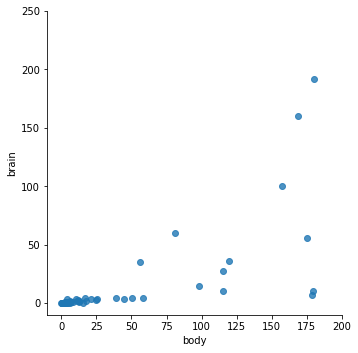

In [13]:
g= sns.lmplot(x='body', y='brain', data=mammals, ci=None, fit_reg=False)
axes = g.axes
ax = axes[0, 0]
ax.set_xlim(-10, 200)
ax.set_ylim(-10, 250);

There appears to be a relationship between brain and body weight for mammals.

<a id="making-a-prediction"></a>
### Making a Prediction

<a id="linear-regression-quick-review"></a>
#### Linear Regression: A Quick Review

<img src="./assets/linear-residuals.png" width=800 /img>

Now let's pretend that a **new mammal species** is discovered. We measure the body weight of every member of this species we can find and calculate an **average body weight of 100 kgs**. We want to **predict the average brain weight** of this species (rather than measuring it directly). How might we do this?

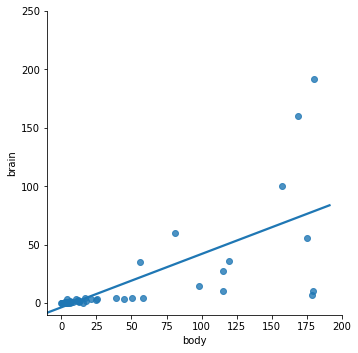

In [14]:
g= sns.lmplot(x='body', y='brain', data=mammals, ci=None)
axes = g.axes
ax = axes[0, 0]
ax.set_xlim(-10, 200)
ax.set_ylim(-10, 250);

We drew a straight line that appears to best capture the relationship between brain and body weight. So, we might predict that our new species has a brain weight of about 45 g, as that's the approximate y value when x=100.

This is known as a "linear model" or a "linear regression model."

<a id="making-a-prediction-from-a-sample"></a>
## Making a Prediction From a Sample

The point of supervised learning is to generalize from the samples we have to samples we don't have. Let's simulate this situation by assigning each of the 51 observations to **either universe 1 or universe 2**:

In [15]:
# Set a random seed for reproducibility.
np.random.seed(12345)

# Randomly assign every observation to either universe 1 or universe 2.
mammals.loc[:, 'universe'] = np.random.randint(1, 3, len(mammals)) # in a way saying give me 51 numbers which are either 1 or 2
mammals.head()

,brain,body,universe
0,3.385,44.5,1
1,0.480,15.5,2
2,1.350,8.1,2
4,36.330,119.5,2
5,27.660,115.0,1


We can now tell Seaborn to create two plots in which the left plot only uses the data from **universe 1** and the right plot only uses the data from **universe 2**:

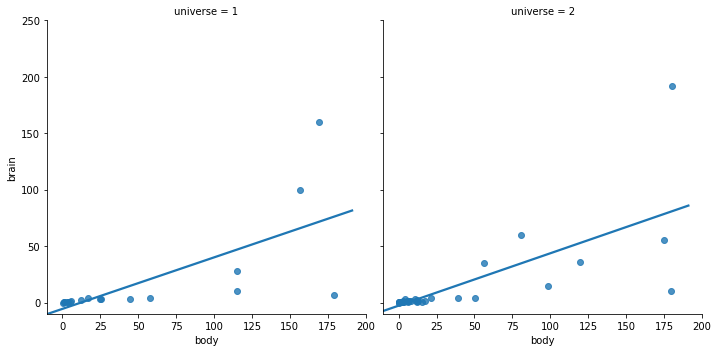

In [16]:
# col='universe' subsets the data by universe and creates two separate plots.
g= sns.lmplot(x='body', y='brain', data=mammals, ci=None, col='universe')
axes = g.axes
ax = axes[0, 0]
ax.set_xlim(-10, 200)
ax.set_ylim(-10, 250);

The line looks pretty similar between the two plots, despite the fact that they used separate samples of data. In both cases, we would predict a brain weight of about 45 g.

It's easier to see the degree of similarity by placing them on the same plot:

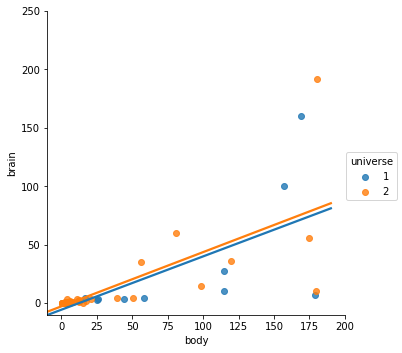

In [17]:
# hue='universe' subsets the data by universe and creates a single plot.
g= sns.lmplot(x='body', y='brain', data=mammals, ci=None, hue='universe')
axes = g.axes
ax = axes[0, 0]
ax.set_xlim(-10, 200)
ax.set_ylim(-10, 250);

**Exercise.** How would you characterize the bias and variance of a linear model for brain size against body size? Justify your answer.

- pretty big errors indicating high bias

- both lines close indicates low variance

<a id="lets-try-something-completely-different"></a>
### Let's Try Something Completely Different

What would a **low-bias, high-variance** model look like? Let's try polynomial regression with an eighth-order polynomial.

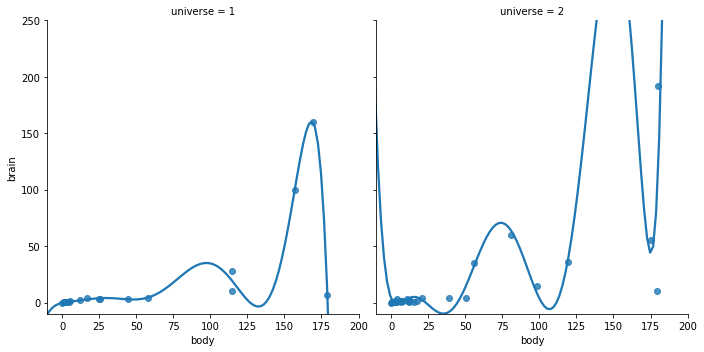

In [21]:
g= sns.lmplot(x='body', y='brain', data=mammals, ci=None, col='universe', order=8) # 8 here is saying change directions of curves upto 7 times
axes = g.axes
ax = axes[0, 0]
ax.set_xlim(-10, 200)
ax.set_ylim(-10, 250);

- It's **low bias** because the models match the data effectively.
- It's **high variance** because the models are widely different, depending on which observations happen to be available in that universe. (For a body weight of 100 kg, the brain weight prediction would be 40 kg in one universe and 0 kg in the other!)

<a id="balancing-bias-and-variance"></a>
## Balancing Bias and Variance
Can we find a middle ground?

Perhaps we can create a model that has **less bias than the linear model** and **less variance than the eighth order polynomial**?

Let's try a second order polynomial instead:

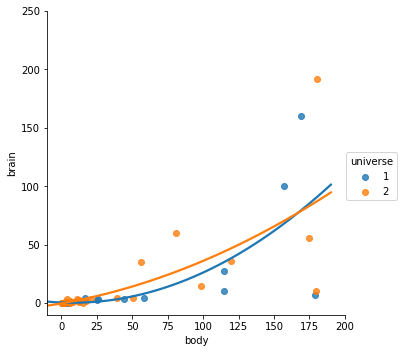

In [22]:
# hue='universe' subsets the data by universe and creates a single plot.
g= sns.lmplot(x='body', y='brain', data=mammals, ci=None, hue='universe', 
             order=2)
axes = g.axes
ax = axes[0, 0]
ax.set_xlim(-10, 200)
ax.set_ylim(-10, 250);

This seems better. In both the left and right plots, **it fits the data well, but not too well**.

This is the essence of the **bias-variance trade-off**: You are seeking a model that appropriately balances bias and variance and thus will generalize to new data (known as "out-of-sample" data).

**Exercise.**

- Why do we care about variance if we know we can generate a more accurate model with higher complexity?

--so that you dont overfit
--may be you have that many features, I mean it may be not available

- **Challenge:** Is it possible for a model that learns from the data to have zero bias and zero variance on a data set that has irreducible error?

--as per machine learning is concerned, if there is error then there cannot be a situation with 0 bias and 0 variance

<a id="train-test-split"></a>
## Model Evaluation

<a id="evaluation-procedure--train-and-test-on-the-entire-dataset-do-not-do-this"></a>
### Evaluation Procedure #1: Train and Test on the Entire Data Set (Do Not Do This)

1. Train the model on the **entire data set**.
2. Test the model on the **same data set** and evaluate how well we did by comparing the **predicted** response values with the **true** response values.

#### Load in the Boston data.

In [23]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_boston

boston = load_boston()

In [24]:
print(boston.DESCR)

Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
      

#### Create X and y variables to store the feature matrix and response from the Boston data.

In [25]:
# Create a DataFrame for both parts of data; don't forget to assign column names.
X = pd.DataFrame(boston.data, columns=boston.feature_names)
y = pd.DataFrame(boston.target, columns=['MEDV'])

#### Concatenate y and X, then overwrite the Boston variable.

In [30]:
boston = pd.concat([y, X], axis=1)

In [31]:
boston.head()

,MEDV,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,24.0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,21.6,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,34.7,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,33.4,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,36.2,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


#### Perform basic EDA to make sure the data are in order.

In [32]:
# Count null values of each variable
boston.isnull().sum()

MEDV       0
CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
dtype: int64

In [ ]:
# Make sure data is numeric


In [33]:
# Look at basic descriptive statistics
boston.describe()

,MEDV,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,22.532806,3.593761,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063
std,9.197104,8.596783,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062
min,5.000000,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000
25%,17.025000,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000
50%,21.200000,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000
75%,25.000000,3.647423,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000
max,50.000000,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000


#### Prepare a feature matrix (X) and response (y)  for scikit-learn.

#### Import linear regression, instantiate, fit, and preview predictions.

In [37]:
# 1. import the model class
from sklearn.linear_model import LinearRegression

# 2. instantiate
lr = LinearRegression()

# 3. train the model
lr.fit(X, y) # note here we are training on the whole data set

# 4 predict the response values for the entire data set
lr.predict(X)

array([[30.00821269],
       [25.0298606 ],
       [30.5702317 ],
       [28.60814055],
       [27.94288232],
       [25.25940048],
       [23.00433994],
       [19.5347558 ],
       [11.51696539],
       [18.91981483],
       [18.9958266 ],
       [21.58970854],
       [20.90534851],
       [19.55535931],
       [19.2837957 ],
       [19.30000174],
       [20.52889993],
       [16.9096749 ],
       [16.17067411],
       [18.40781636],
       [12.52040454],
       [17.67104565],
       [15.82934891],
       [13.80368317],
       [15.67708138],
       [13.3791645 ],
       [15.46258829],
       [14.69863607],
       [19.54518512],
       [20.87309945],
       [11.44806825],
       [18.05900412],
       [ 8.78841666],
       [14.27882319],
       [13.69097132],
       [23.81755469],
       [22.34216285],
       [23.11123204],
       [22.91494157],
       [31.35826216],
       [34.21485385],
       [28.0207132 ],
       [25.20646572],
       [24.61192851],
       [22.94438953],
       [22

#### Store the predicted response values.

In [40]:
y_pred = lr.predict(X)


In [41]:
y_pred

array([[30.00821269],
       [25.0298606 ],
       [30.5702317 ],
       [28.60814055],
       [27.94288232],
       [25.25940048],
       [23.00433994],
       [19.5347558 ],
       [11.51696539],
       [18.91981483],
       [18.9958266 ],
       [21.58970854],
       [20.90534851],
       [19.55535931],
       [19.2837957 ],
       [19.30000174],
       [20.52889993],
       [16.9096749 ],
       [16.17067411],
       [18.40781636],
       [12.52040454],
       [17.67104565],
       [15.82934891],
       [13.80368317],
       [15.67708138],
       [13.3791645 ],
       [15.46258829],
       [14.69863607],
       [19.54518512],
       [20.87309945],
       [11.44806825],
       [18.05900412],
       [ 8.78841666],
       [14.27882319],
       [13.69097132],
       [23.81755469],
       [22.34216285],
       [23.11123204],
       [22.91494157],
       [31.35826216],
       [34.21485385],
       [28.0207132 ],
       [25.20646572],
       [24.61192851],
       [22.94438953],
       [22

We need a measure of model performance. The most common choices for regression problems are:

- **R-squared**: The percentage of variance captured by the model.
- **Mean squared error**: The average squared distance between the prediction and the correct answer.

We'll use mean squared error.

#### Compute mean squared error using a function from `metrics`.

In [42]:
from sklearn import metrics

help(metrics.mean_squared_error)

Help on function mean_squared_error in module sklearn.metrics.regression:

mean_squared_error(y_true, y_pred, sample_weight=None, multioutput='uniform_average')
    Mean squared error regression loss
    
    Read more in the :ref:`User Guide <mean_squared_error>`.
    
    Parameters
    ----------
    y_true : array-like of shape = (n_samples) or (n_samples, n_outputs)
        Ground truth (correct) target values.
    
    y_pred : array-like of shape = (n_samples) or (n_samples, n_outputs)
        Estimated target values.
    
    sample_weight : array-like of shape = (n_samples), optional
        Sample weights.
    
    multioutput : string in ['raw_values', 'uniform_average']
        or array-like of shape (n_outputs)
        Defines aggregating of multiple output values.
        Array-like value defines weights used to average errors.
    
        'raw_values' :
            Returns a full set of errors in case of multioutput input.
    
        'uniform_average' :
            Er

In [43]:
metrics.mean_squared_error(y, y_pred) # mean square on a training set

21.8977792176875

This is known as the **training mean squared error** because we are evaluating the model based on the same data we used to train the model.

<a id="problems-with-training-and-testing-on-the-same-data"></a>
### Problem With Training and Testing on the Same Data

Maximizing the MSE on **in-sample data** rewards high-variance/low-bias models that fit the noise in the training data as well as the signal.

Our goal is to estimate likely performance of a model on **out-of-sample data**, so a better approach is to put some data aside as a test set.

<a id="evaluation-procedure--traintest-split"></a>
### Evaluation procedure #2: Train/Test Split

1. Split the data set into two pieces: a **training set** and a **testing set**.
2. Train the model on the **training set**.
3. Test the model on the **testing set** and evaluate how well we did.

A common rule of thumb is to set aside 30% of your data set for testing.

**Testing MSE is a better estimate of out-of-sample performance than training MSE.**

#### Understanding the `train_test_split` Function

In [51]:
from sklearn.model_selection import train_test_split

np.random.seed(123)

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [53]:
print(X_train.index)
print(y_train.index)

Int64Index([335, 142, 170, 241, 379, 367, 388, 156, 433,  31,
            ...
            123, 106,  83,  17, 230,  98, 476, 322, 382, 365],
           dtype='int64', length=379)
Int64Index([335, 142, 170, 241, 379, 367, 388, 156, 433,  31,
            ...
            123, 106,  83,  17, 230,  98, 476, 322, 382, 365],
           dtype='int64', length=379)


![train_test_split](./assets/train_test_split.png)

#### Understanding the `random_state` Parameter

The `random_state` is a pseudo-random number that allows us to reproduce our results every time we run them. However, it makes it impossible to predict what are exact results will be if we chose a new `random_state`.

`random_state` is very useful for testing that your model was made correctly since it provides you with the same split each time. However, make sure you remove it if you are testing for model variability!

In [ ]:
# WITHOUT a random_state parameter:
#  (If you run this code several times, you get different results!)
X_train, X_test, y_train, y_test = train_test_split(X, y)

# Print the first element of each object.
print(X_train.head(1))

In [ ]:
# WITH a random_state parameter:
#  (Same split every time! Note you can change the random state to any integer.)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

# Print the first element of each object.
print(X_train.head(1))
print(X_test.head(1))
print(y_train.head(1))
print(y_test.head(1))

#### Step 1: Split X and y into training and testing sets (using `random_state` for reproducibility).

In [59]:
y = boston.loc[:, 'MEDV']
X = boston.loc[:, ['AGE', 'RM']]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)

#### Step 2: Train the model on the training set.

In [60]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

#### Step 3: Test the model on the testing set and check the accuracy.

In [61]:
y_pred = lr.predict(X_test)

print(' Training MSE: ',
    metrics.mean_squared_error(y_train, lr.predict(X_train))
     )


print(' Test MSE: ',
    metrics.mean_squared_error(y_test, lr.predict(X_test))
     )

 Training MSE:  37.87549052631233
 Test MSE:  45.13214982790762



![Bias-variance tradeoff](./assets/bias_variance.png)

#### Go back to Step 1 and try adding new variables and transformations.

- **Training error**: Decreases as model complexity increases (lower value of k).
- **Testing error**: Is minimized at the optimum model complexity.

<a id="comparing-test-performance-with-a-null-baseline"></a>
### Comparing Test Performance With a Null Baseline

How do you know if your model is any good?

It helps to have benchmarks to compare against. A very simple model can provide a *baseline* that you can use to check whether your model is complete garbage or not.

A good baseline for linear regression is a model that just predicts the mean of the target variable every time.

In [65]:
# Use .apply() to broadcast a mean for every prediction.
metrics.mean_squared_error(y_test, 
                           pd.DataFrame(y_test).apply(np.mean, broadcast=True))

78.9422382044764

**Exercise.** What does this result tell us about our linear regression model?

<a id="k-folds-cross-validation"></a>
## K-Folds Cross-Validation
---

A simple train/test split has at least two drawbacks:

- Setting aside a test set that is large enough to provide a good estimate of performance can get in the way of training and lead you to choose a simpler model than you would need to do well when training on the full data set.
- Evaluating many models on the same test set can lead to overfitting on the test set.

**Solution:** Train the model on k separate train-test-splits, then average the resulting evaluation metric values.

![](./assets/cross_validation_diagram.png)

This approach allows you to make each test set smaller while still getting a good estimate of accuracy and makes it harder to overfit to the test set by using all of the test set for evaluation.

<a id="leave-one-out-cross-validation"></a>
### Leave-One-Out Cross-Validation

An extreme case of k-fold cross-validation is leave-one-out cross-validation, where you hold out just one data point at a time.

This approach is great for making the best use of the training data while getting a good estimate of performance. However, it can be *very slow* because it requires fitting your model $n$ times.

A more common approach is to set $k$ somewhere between 5 and 10.

<a id="intro-to-cross-validation-with-the-boston-data"></a>
### Intro to Cross-Validation With the Boston Data

#### Create a cross-validation with five folds.

In [70]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True)


In [71]:
list(kf.split(X, y))

[(array([  2,   3,   4,   5,   7,   8,   9,  10,  11,  13,  14,  15,  16,
          17,  19,  20,  23,  24,  25,  26,  27,  28,  29,  30,  32,  33,
          37,  39,  40,  43,  44,  45,  46,  47,  49,  50,  51,  52,  55,
          56,  57,  58,  59,  60,  62,  65,  66,  67,  68,  69,  71,  72,
          73,  74,  75,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,
          88,  89,  90,  91,  92,  95,  96,  97,  98,  99, 100, 101, 102,
         105, 106, 108, 109, 110, 111, 112, 114, 116, 117, 118, 119, 120,
         121, 123, 124, 125, 127, 128, 129, 130, 132, 133, 134, 135, 136,
         137, 138, 139, 140, 141, 142, 143, 144, 145, 147, 148, 149, 150,
         151, 152, 153, 154, 155, 157, 158, 159, 160, 162, 163, 164, 165,
         166, 169, 172, 173, 175, 176, 177, 178, 180, 181, 182, 184, 185,
         186, 187, 188, 189, 190, 192, 193, 194, 195, 197, 198, 199, 200,
         201, 202, 203, 204, 205, 206, 207, 208, 209, 211, 212, 213, 215,
         216, 217, 218, 219, 220, 221,

In [77]:
mse_values = []
r2_values = []
n = 0

for train_index, test_index in kf.split(X, y):
    lr = LinearRegression()
    X_train = X.loc[train_index, :]
    y_train = y.loc[train_index]
    lr.fit(X_train, y_train)
    
    X_test = X.loc[test_index, :]
    y_test = y.loc[test_index]
    
    r2 = lr.score(X_test, y_test)
    r2_values.append(r2)
    
    mse = metrics.mean_squared_error(y_test, lr.predict(X_test))
    mse_values.append(mse)
    
    
    n += 1
    
    print('Model', n)
    print('MSE:', mse)
    print('R2:', r2)
    print()
                                     
                                     
    

Model 1
MSE: 25.325604126054884
R2: 0.6358749711692324

Model 2
MSE: 48.885530782762565
R2: 0.4687046464134005

Model 3
MSE: 46.73442503050167
R2: 0.3793171013287163

Model 4
MSE: 45.168893779755756
R2: 0.5108309497094617

Model 5
MSE: 38.52066510780929
R2: 0.557774070143062



In [78]:
sum(mse_values)/len(mse_values)

40.92702376537683

In [79]:
sum(r2_values)/len(r2_values)

0.5105003477527745

<a id="three-way-data-split"></a>
## Three-Way Data Split
---
Goodhart's law: "When a measure becomes a target, it ceases to be a good measure."

Cross-validation performance provides an upwardly biased estimate of out-of-sample performance when you use it to select a model, even with $k$-fold cross validation.

If you care about being able to estimate model performance after tuning by cross-validation, then you should set aside a true test set from the beginning that you don't use even in cross-validation.

![](./assets/Train-Test-Split-CV.png)

- If you care about having an unbiased estimate of model performance when you are done, then you should split your data three ways:
    - **Training set**: A set of examples used for learning – what parameters of the classifier?
    - **Validation set**: A set of examples used to tune the parameters of the classifier.
    - **Testing set**: A set of examples used ONLY to assess the performance of the fully trained classifier.
- The training-validation split can be k-fold.
- Validation and testing must be separate data sets. Once you have the final model set, you cannot do any additional tuning after testing.

**Steps for a three-way split**

1. Set aside a testing set.
2. Select architecture (model type) and training parameters ($k$).
3. Train the model using the training set and evaluate it using the validation set (using either simple or k-fold train/test split).
4. Repeat, selecting different architectures (models) and tuning parameters.
5. Select the best model.
6. Assess the model with the final testing set.

<a id="additional-resources"></a>
<a id="additional-resources"></a>
### Additional Resources
- [Bias Variance](http://scott.fortmann-roe.com/docs/BiasVariance.html)
- University of Washington [slides](https://courses.cs.washington.edu/courses/cse546/12wi/slides/)

<a id="summary"></a>
### Summary

In this lab, we compared four methods of estimating model accuracy on out-of-sample data:

1. **Train on the entire dataset**
2. **Simple train/test split**
3. **K-folds cross validation**
4. **Three-way split**

# Questions?

# [Exit Tickets](https://docs.google.com/forms/d/1BW4rVsCx8Nzp3q2B7SQ_tL1xqKZr4GGoQ5qeZfayxh4/viewform?ts=5ad40144&edit_requested=true)